In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import seaborn as sns
import json
import pandas as pd

from sklearn.utils import shuffle
import pickle as pkl
import tensorflow as tf

import random 
# # Make reproducible
seed = 1
np.random.seed(seed)

In [4]:
# Path to the IPython notebook file (replace with your actual file path)
notebook_path = 'C:/Users/Artgur/Desktop/Uni/MA/BNN/Code/Load_data.ipynb'

# Load the notebook
with open(notebook_path, 'r') as file:
    notebook = json.load(file)

# Remove the outputs and execution counts
for cell in notebook['cells']:
    if cell['cell_type'] == 'code':
        cell['outputs'] = []
        cell['execution_count'] = None

# Save the modified notebook
with open(notebook_path, 'w') as file:
    json.dump(notebook, file, indent=2)

In [5]:
grib_file_path = 'C:/Users/Artgur/Desktop/Uni/MA/BNN/Data/GroundTruth'
grib_files = [os.path.join(grib_file_path, f) for f in os.listdir(grib_file_path) if f.endswith('.grib')]

t2_dataset = [xr.open_dataset(file, engine='cfgrib', backend_kwargs={'filter_by_keys': {'shortName': "2t"}}) for file in grib_files]
tp_dataset = [xr.open_dataset(file, engine='cfgrib', backend_kwargs={'filter_by_keys': {'shortName': "tp"}}) for file in grib_files]


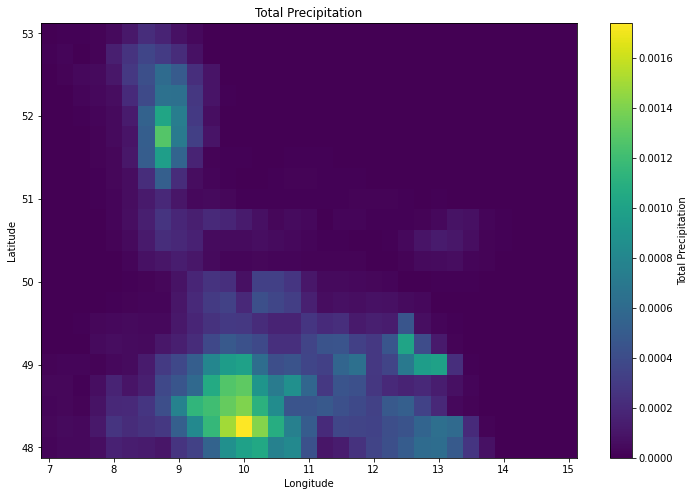

In [6]:
ds = tp_dataset[0] 
data_to_plot = ds.tp.isel(time=1, step=1)

longitude = ds.longitude.values
latitude = ds.latitude.values

plt.figure(figsize=(12, 8))
plt.pcolormesh(longitude, latitude, data_to_plot, shading='nearest')
plt.colorbar(label='Total Precipitation')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Total Precipitation')
plt.show()

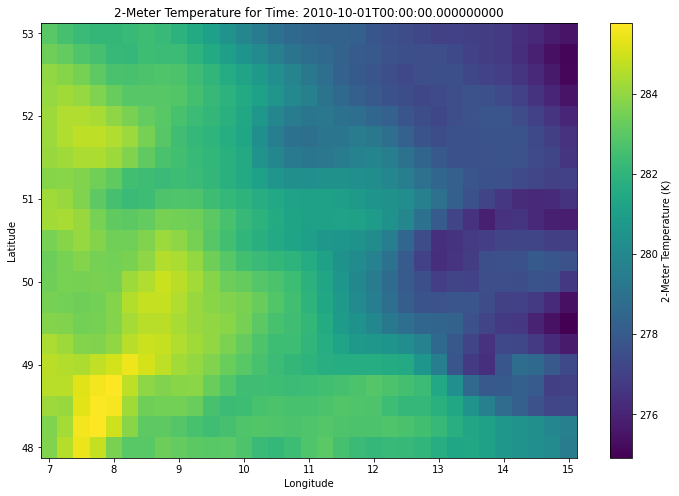

In [7]:
ds = t2_dataset[0]
data_to_plot = ds.t2m.isel(time=1)

longitude = ds.longitude.values
latitude = ds.latitude.values

plt.figure(figsize=(12, 8))
plt.pcolormesh(longitude, latitude, data_to_plot, shading='nearest')
plt.colorbar(label='2-Meter Temperature (K)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'2-Meter Temperature for Time: {ds.time.values[0]}')
plt.show()

In [8]:
t2_all = xr.combine_by_coords(t2_dataset, combine_attrs='drop')
tp_all = xr.combine_by_coords(tp_dataset, combine_attrs='drop')

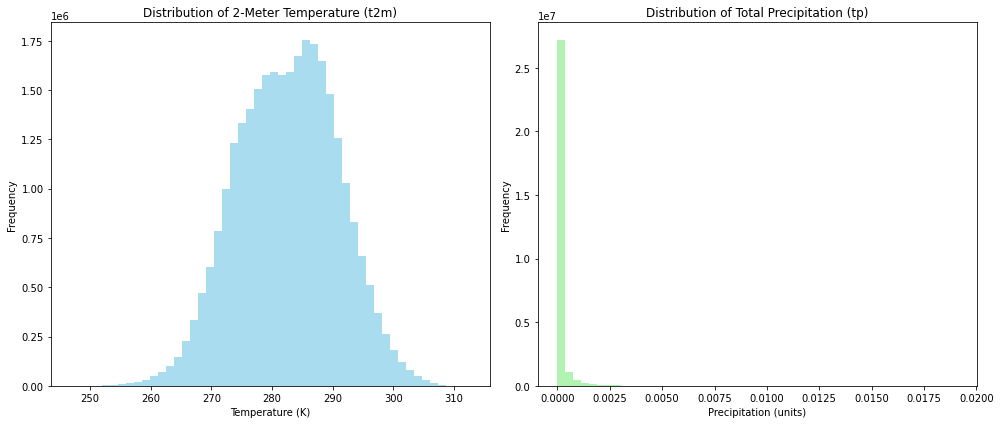

In [9]:
plt.figure(figsize=(14, 6))

# Histogram for 't2m'
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.hist(t2_all.t2m.values.flatten(), bins=50, color='skyblue', alpha=0.7)
plt.title('Distribution of 2-Meter Temperature (t2m)')
plt.xlabel('Temperature (K)')
plt.ylabel('Frequency')

# Histogram for 'tp'
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.hist(tp_all.tp.values.flatten(), bins=50, color='lightgreen', alpha=0.7)
plt.title('Distribution of Total Precipitation (tp)')
plt.xlabel('Precipitation (units)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [10]:
# Take out data from xarray.Dataset
time = pd.to_datetime(t2_all.time.values)
latitudes = t2_all.latitude.values
longitudes = t2_all.longitude.values

# Flatten the data for 't2m' to prepare for NN input
t2m_values = t2_all.t2m.values.flatten()

# Prepare the latitude, longitude, and time data to match the flattened 't2m' data
lat_data = np.repeat(latitudes, len(longitudes)*len(time))
lon_data = np.tile(np.repeat(longitudes, len(latitudes)), len(time))
time_data = np.tile(time, len(latitudes)*len(longitudes))

# Convert time_data to a more suitable format for NN
time_data = time_data.astype('datetime64[D]').astype(int)

# Combine these into a DataFrame
t2_df = pd.DataFrame({
    'latitude': lat_data,
    'longitude': lon_data,
    'time': time_data,
    't2m': t2m_values
})

t2_df['time'] = pd.to_datetime(t2_df['time'], unit='D', origin='1970-01-01')
t2_df['month'] = t2_df['time'].dt.month
month = t2_df['month']


In [11]:
# Convert 'time' and 'step' to numpy arrays for direct operations
time = pd.to_datetime(tp_all.time.values)
steps = tp_all.step.values.astype('timedelta64[h]').astype(int)

# Create a 3D grid for 'time', 'latitude', 'longitude', and 'step'
# This avoids explicitly repeating and tiling the coordinate and time arrays
mesh_time, mesh_step, mesh_lat, mesh_lon = np.meshgrid(time, steps, tp_all.latitude.values, tp_all.longitude.values, indexing='ij')

# Flatten the mesh grids
time_flat = mesh_time.ravel()
step_flat = mesh_step.ravel()
lat_flat = mesh_lat.ravel()
lon_flat = mesh_lon.ravel()

# Calculate the combined time with step directly
combined_time = pd.to_datetime(time_flat) + pd.to_timedelta(step_flat, unit='h')

# Flatten the 'tp' data
tp_values = tp_all.tp.values.reshape(-1)  # Using reshape(-1) to flatten

# Create the DataFrame directly with the combined time
df_tp = pd.DataFrame({
    'time_with_step': combined_time,
    'latitude': lat_flat,
    'longitude': lon_flat,
    'tp': tp_values
})


df_tp.fillna(0, inplace=True)

t2_df["time"] = pd.to_datetime(t2_df["time"])
min_date = t2_df["time"].min()
t2_df["mons"] = ((t2_df["time"].dt.year - min_date.year) * 12 + t2_df["time"].dt.month - min_date.month) + 1 

In [20]:
df = pd.read_pickle("c:/Users/Artgur/Downloads/refC1SD_MINMAX_64x128_raw.pkl")


In [2]:
df

NameError: name 'df' is not defined

In [30]:
# Setup for saving
save_path = 'savedir/{}'

# Apply coordinate mapping lat,lon -> x,y,z
lon = t2_df['longitude'] * np.pi / 180
lat = t2_df['latitude'] * np.pi / 180
x = np.cos(lat) * np.cos(lon)
y = np.cos(lat) * np.sin(lon)
z = np.sin(lat)

# Apply coordinate mapping month_number -> x_mon, y_mon
rads = (df['month'] * 360/12) * (np.pi / 180)
x_mon = np.sin(rads)
y_mon = np.cos(rads)

# min-max scale months
mons_scaled = 2 * (df['mons'] - df['mons'].min())/(df['mons'].max() - df['mons'].min()) - 1

# Remove old coords and add new mapped coords from/to dataframe
df = df.drop(['lat', 'lon', 'month', 'mons'], axis=1)
df['x'] = x
df['y'] = y 
df['z'] = z
df['x_mon'] = x_mon
df['y_mon'] = y_mon
df['mons'] = mons_scaled

# Apply min-max scaling to each model and observations
y_min = df['t2m'].min()
y_max = df['t2m'].max()
# for i in range(16): # 15 models and 1 obs
#     mdl = df[df.columns[i]]
#     df[df.columns[i]] = 2 * (mdl - mdl.min())/(mdl.max() - mdl.min()) - 1
    
# Apply coordinate scaling
df['x'] = df['x'] * 2
df['y'] = df['y'] * 2
df['z'] = df['z'] * 2

df['x_mon'] = df['x_mon'] * 2
df['y_mon'] = df['y_mon'] * 2
df['mons'] = df['mons'] * 1.0

cols_to_drop = ['has_obs', 'train_mask', 'test_mask', 'interp_mask', 'extrap_mask']
# Maintain shuffling with seed
df_train = df[df['train_mask']].drop(cols_to_drop, axis=1)
df_test = df[df['test_mask']].drop(cols_to_drop, axis=1)
df_interp = df[df['interp_mask']].drop(cols_to_drop, axis=1)
df_extrap = df[df['extrap_mask']].drop(cols_to_drop, axis=1)
n_obs = np.sum(df['has_obs'].values)

print('Training on {:.1f}%'.format(100 * len(df_train)/n_obs))
print('Testing on {:.1f}%'.format(100 * len(df_test)/n_obs))
print('Validation (interpolation) on {:.1f}%'.format(100 * len(df_interp)/n_obs))
print('Validation (extrapolation) on {:.1f}%'.format(100 * len(df_extrap)/n_obs))

# In sample training
X_train = df_train.drop(['obs_toz'],axis=1).values
y_train = df_train['obs_toz'].values.reshape(-1,1)

# The in sample testing - this is not used for training
X_test = df_test.drop(['obs_toz'],axis=1).values
y_test = df_test['obs_toz'].values.reshape(-1,1)

# For all time
X_at = df.drop(['obs_toz'],axis=1).drop(cols_to_drop, axis=1).values
y_at = df.drop(cols_to_drop, axis=1)['obs_toz'].values.reshape(-1,1)



KeyboardInterrupt



In [7]:
def detailed_fun_region(time, lat, lon, month, lat_min, lat_max, lon_min, lon_max):
    # Normalize latitude and longitude to the region
    norm_lat = (lat - lat_min) / (lat_max - lat_min)
    norm_lon = (lon - lon_min) / (lon_max - lon_min)
    
    # Enhanced function with added complexity
    f = (0.5 * (norm_lat ** 2) + 0.5 * np.sin(2 * np.pi * norm_lon)) \
        - 0.2 * np.cos(2 * np.pi * month / 12) \
        + 0.1 * np.sin(4 * np.pi * norm_lat) * np.cos(4 * np.pi * norm_lon) \
        - 0.1 * np.cos(2 * np.pi * time / 365)
    
    # Scale the function output to increase detail sensitivity within the region
    scale_factor = 1 + (lat_max - lat_min) / 90 + (lon_max - lon_min) / 180
    f *= scale_factor
    
    return f

n_years = 20
lats = np.arange(30, 50, 180/48)
lons = np.arange(-10,20, 360/96)
# Change time so the in sample runs -1, 1
time = np.arange(-1,1, (2/12)/n_years) * 2 + 1
months = np.tile(np.arange(-1,1,2/12), n_years)

lat_min, lat_max = 30, 50  
lon_min, lon_max = -10, 20  
lat = 40 
lon = 5 


obs = np.zeros([len(time), len(lats), len(lons)])
for i, t in enumerate(time):
    for j, lat in enumerate(lats):
        for k, lon in enumerate(lons):
            obs[i, j, k] = detailed_fun_region(t, lat, lon, months[i])

# Call the enhanced function
# detailed_observation = detailed_fun_region(time, lat, lon, month, lat_min, lat_max, lon_min, lon_max)
# print("Detailed observation for smaller region:", detailed_observation)

TypeError: object of type 'int' has no len()

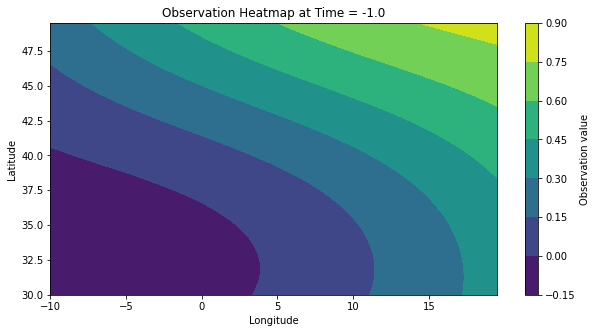

In [28]:
# Create fake dimensions (lat, lon, months, time)
n_years = 20
lats = np.arange(30, 50, 0.5)
lons = np.arange(-10,20, 0.5)
# Change time so the in sample runs -1, 1
time = np.arange(-1,1, (2/12)/n_years) * 2 + 1
months = np.tile(np.arange(-1,1,2/12), n_years)

# Create smooth function to serve as the observational truth
def fun(time, lat, lon, month):
    f = (0.5 * (((lat / 90) ** 2) + 0.5 * np.sin(2 * np.pi * lon / 180)) - 0.2 * np.cos(np.pi * month) + 
         0.1 * np.sin(4 * np.pi * lat / 90) * np.cos(4 * np.pi * lon / 180) - 0.05 * np.cos(2 * np.pi * time) + 0.05 * np.sin(2 * np.pi * lat / 45) * np.sin(2 * np.pi * lon / 90)) 
    return f

obs = np.zeros([len(time), len(lats), len(lons)])
for i, t in enumerate(time):
    for j, lat in enumerate(lats):
        for k, lon in enumerate(lons):
            obs[i, j, k] = fun(t, lat, lon, months[i])
            
# Normalise obs
obs = 2 * (obs - obs.min())/(obs.max() - obs.min()) - 1


# Select the time point to plot - for example, the first time point
time_index = 0

# Create a meshgrid for plotting
lat_grid, lon_grid = np.meshgrid(lats, lons, indexing='ij')

# Plotting
plt.figure(figsize=(10, 5))
plt.contourf(lon_grid, lat_grid, obs[time_index, :, :], cmap='viridis')
plt.colorbar(label='Observation value')
plt.title(f'Observation Heatmap at Time = {time[time_index]}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# Format data so it is suitable for NN input
data_len = obs.size
lon_data = np.tile(lons, int(data_len / len(lons))).reshape(-1,)
lat_data = np.tile(np.repeat(lats, len(lons)), len(time)).reshape(-1,)
time_data = np.repeat(time, int(data_len / len(time))).reshape(-1,)
mon_data = np.repeat(months, int(data_len / len(time))).reshape(-1,)

# model 1  True in the north with a -0.03 bias
mdl1 = obs.copy() - 0.03 + np.random.normal(size=[len(time), len(lats), len(lons)]) * 0.005
mdl1[:,:-16, :] = np.random.random([len(time), len(lats) - 16, len(lons)]) * 2 - 1

# model 2 True around equator with no bias
mdl2 = obs.copy() + np.random.normal(size=[len(time),len(lats), len(lons)]) * 0.005 
mdl2[:,:16, :] = np.random.random([len(time), 16, len(lons)]) * 2 - 1
mdl2[:,-16:, :] = np.random.random([len(time), 16, len(lons)]) * 2 - 1

# model 3 True around equator with no bias (as per model 2)
mdl3 = obs.copy() + np.random.normal(size=[len(time), len(lats), len(lons)]) * 0.005
mdl3[:,:16, :] = np.random.random([len(time), 16, len(lons)]) * 2 - 1
mdl3[:,-16:, :] = np.random.random([len(time), 16, len(lons)]) * 2 - 1

# model 4 True in the south with 0.03 bias. True only for months 1-6
mdl4 = obs.copy() + 0.03 + np.random.normal(size=[len(time), len(lats), len(lons)]) * 0.005
mdl4[:,16:, :] = np.random.random([len(time), len(lats) - 16, len(lons)]) * 2 - 1

# Add noise
# In the north we have 0.01 noise
obs[:,-16:, :] = obs[:,-16:, :] + np.random.normal(size=obs[:,-16:, :].shape) * 0.01
# Around the equator we have 0.02 noise
obs[:,16:-16, :] = obs[:,16:-16, :] + np.random.normal(size=obs[:,16:-16, :].shape) * 0.02
# In the south we have 0.03 noise
obs[:,:16, :] = obs[:,:16, :] + np.random.normal(size=obs[:,:16, :].shape) * 0.03

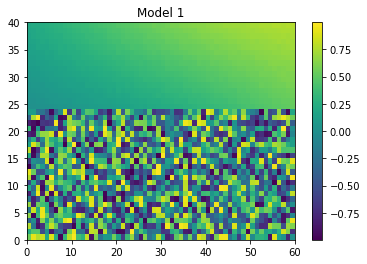

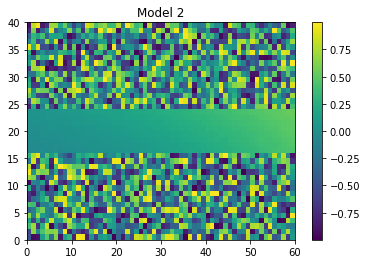

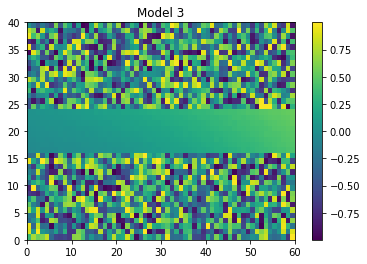

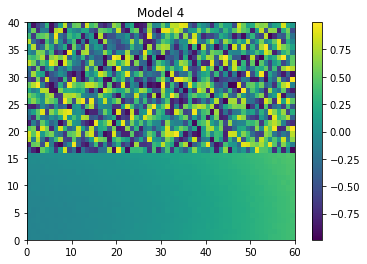

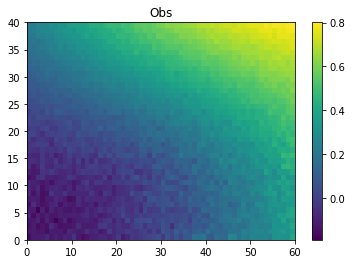

In [29]:
plt.figure()
plt.pcolormesh(mdl1[0])
plt.title('Model 1')
plt.colorbar()
plt.show()
plt.figure()
plt.pcolormesh(mdl2[0])
plt.title('Model 2')
plt.colorbar()
plt.show()
plt.figure()
plt.pcolormesh(mdl3[0])
plt.title('Model 3')
plt.colorbar()
plt.show()
plt.figure()
plt.pcolormesh(mdl4[0])
plt.title('Model 4')
plt.colorbar()
plt.show()
plt.figure()
plt.pcolormesh(obs[0])
plt.title('Obs')
plt.colorbar()
plt.show()